In [8]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import regexp_extract, monotonically_increasing_id
from pyspark.sql.types import FloatType

# Initialize Spark Session
spark = SparkSession.builder.appName("ReviewsParser").getOrCreate()

# Read the text file
rdd = spark.sparkContext.textFile("gs://dataproc-staging-us-east1-766635705898-g9ye7adw/final_project/output5.txt")

# Initialize an empty list to collect rows
rows = []

# Temporary dictionary to store current review data
current_review = {}
for line in rdd.collect():
    if line.startswith("product/productId:"):
        # Start of a new review
        if current_review:
            # Add the completed review to the list
            rows.append(Row(**current_review))
            current_review = {}

    elif line.startswith("review/score:"):
        current_review["score"] = float(line.split(": ")[1])

    elif line.startswith("review/time:"):
        current_review["time"] = line.split(": ")[1]

    elif line.startswith("review/summary:"):
        current_review["summary"] = line.split(": ", 1)[1]

    elif line.startswith("review/text:"):
        current_review["text"] = line.split(": ", 1)[1]

    elif line.startswith("review/helpfulness:"):
        current_review["helpfulness"] = line.split(": ")[1]

# Don't forget to add the last review
if current_review:
    rows.append(Row(**current_review))

# Create an RDD from the list of rows
reviews_rdd = spark.sparkContext.parallelize(rows)

# Create DataFrame from RDD
df = spark.createDataFrame(reviews_rdd)

# Generate ID column
df = df.withColumn("id", monotonically_increasing_id())

# Calculate 'helpfulness' ratio
df = df.withColumn("helpfulness_ratio", 
                   (regexp_extract("helpfulness", r"(\d+)/", 1).cast(FloatType()) / 
                    regexp_extract("helpfulness", r"/(\d+)", 1).cast(FloatType())))


df0 = df.select("id", "score", "time", "summary", "text", "helpfulness_ratio")
df0.show()

23/11/17 21:26:59 WARN TaskSetManager: Stage 18 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/17 21:27:00 WARN TaskSetManager: Stage 19 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----------+--------------------+--------------------+------------------+
| id|score|      time|             summary|                text| helpfulness_ratio|
+---+-----+----------+--------------------+--------------------+------------------+
|  0|  3.0|1182729600|"There Is So Much...|Synopsis: On the ...|               1.0|
|  1|  3.0|1181952000|Worthwhile and Im...|THE VIRGIN OF JUA...|               1.0|
|  2|  5.0|1164844800|This movie needed...|The scenes in thi...|               0.8|
|  3|  3.0|1197158400|distantly based o...|THE VIRGIN OF JUA...|               1.0|
|  4|  3.0|1188345600|"What's going on ...|Informationally, ...|               1.0|
|  5|  2.0|1229040000|Pretty pointless ...|The murders in Ju...|              null|
|  6|  1.0|1164153600|This is junk, sta...|Mexican men are m...|0.2727272727272727|
|  7|  5.0|1060473600|A  Rock N Roll Hi...|Over the past few...|0.9846153846153847|
|  8|  5.0|1041292800|A  MUST-HAVE  vid...|I recvd this vide...|            

In [9]:
# Get the number of rows
num_rows = df0.count()

# Get the number of columns
num_columns = len(df0.columns)

# Print the shape of the DataFrame
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

23/11/17 21:27:09 WARN TaskSetManager: Stage 20 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows: 394382
Number of columns: 6


In [10]:
df0.schema

StructType([StructField('id', LongType(), False), StructField('score', DoubleType(), True), StructField('time', StringType(), True), StructField('summary', StringType(), True), StructField('text', StringType(), True), StructField('helpfulness_ratio', DoubleType(), True)])

In [12]:
from pyspark.sql.functions import col, sum

# Calculate the number of missing values in each column
df_missing = df0.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df0.columns))
df_missing.show()

23/11/17 21:28:48 WARN TaskSetManager: Stage 26 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----+-------+----+-----------------+
| id|score|time|summary|text|helpfulness_ratio|
+---+-----+----+-------+----+-----------------+
|  0|    0|   0|      0|   0|            99439|
+---+-----+----+-------+----+-----------------+



In [13]:
# Drop rows with any missing value
df0 = df0.dropna()
df0_missing = df0.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df0.columns))
df0_missing.show()

23/11/17 21:28:56 WARN TaskSetManager: Stage 29 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----+-------+----+-----------------+
| id|score|time|summary|text|helpfulness_ratio|
+---+-----+----+-------+----+-----------------+
|  0|    0|   0|      0|   0|                0|
+---+-----+----+-------+----+-----------------+



In [14]:
# Get the number of rows
num_rows = df0.count()

# Get the number of columns
num_columns = len(df0.columns)

# Print the shape of the DataFrame
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

23/11/17 21:29:01 WARN TaskSetManager: Stage 32 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows: 294943
Number of columns: 6


In [15]:
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev

# Calculating the mean for the 'score' column
mean_value = df0.select(mean(df0['score'])).collect()[0][0]
mean_value1 = df0.select(mean(df0['helpfulness_ratio'])).collect()[0][0]
std_dev_helpfulness = df0.select(stddev(df0['helpfulness_ratio'])).collect()[0][0]
median_helpfulness = df0.stat.approxQuantile('helpfulness_ratio', [0.5], 0.0)[0]

print("Mean of score:", mean_value)
print("Mean of helpfulness_ratio:", mean_value1)
print("Standard Deviation of helpfulness_ratio:", std_dev_helpfulness)
print("Median of helpfulness_ratio:", median_helpfulness)

23/11/17 21:29:09 WARN TaskSetManager: Stage 35 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/17 21:29:11 WARN TaskSetManager: Stage 38 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/17 21:29:14 WARN TaskSetManager: Stage 41 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/17 21:29:17 WARN TaskSetManager: Stage 44 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Mean of score: 3.9550014748612443
Mean of helpfulness_ratio: 0.6252434793335766
Standard Deviation of helpfulness_ratio: 0.366653276007436
Median of helpfulness_ratio: 0.6666666666666666


23/11/17 21:29:47 WARN TaskSetManager: Stage 45 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


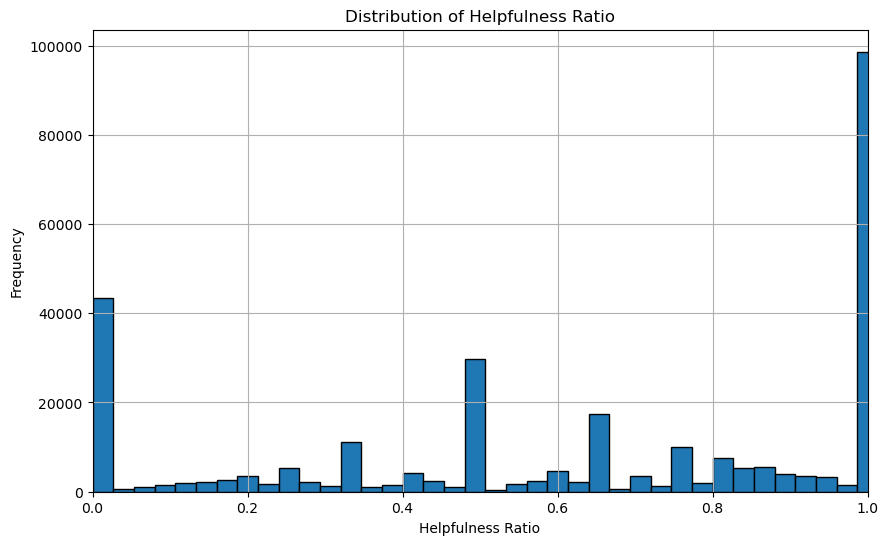

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
helpfulness_pd = df0.select("helpfulness_ratio").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(helpfulness_pd['helpfulness_ratio'], bins=300, edgecolor='black')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 1)  # Setting the limit for the X-axis
plt.grid(True)
plt.show()


In [26]:
# Check unique values in the 'score' column
unique_scores = df0.select("score").distinct().orderBy("score").collect()
print("Unique scores:", [row.score for row in unique_scores])


23/11/17 21:55:05 WARN TaskSetManager: Stage 55 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Unique scores: [1.0, 2.0, 3.0, 4.0, 5.0]


23/11/17 22:16:18 WARN TaskSetManager: Stage 98 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


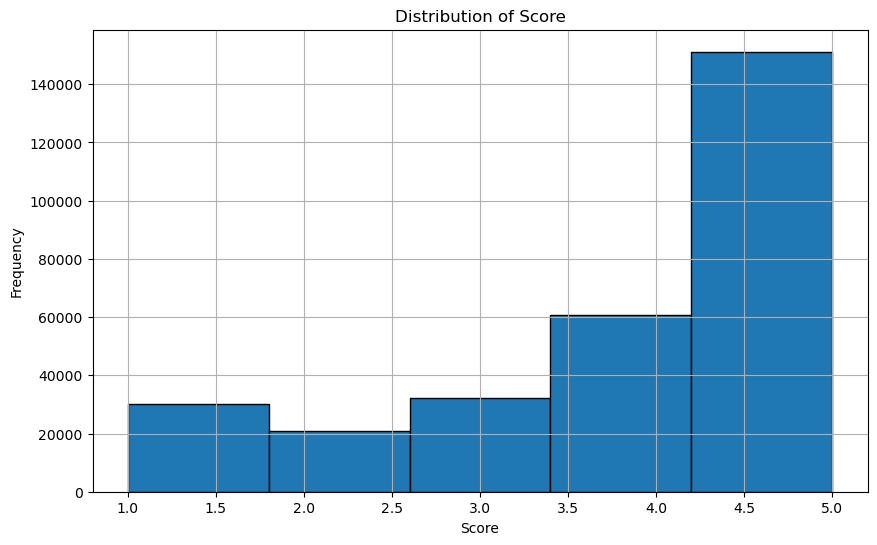

In [42]:
score_pd = df0.select("score").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(helpfulness_pd['score'], bins=5, edgecolor='black')
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [68]:
# Select columns for df_X and df_y
df_X = df0.select("id", "score", "time", "summary", "text")
df_y = df0.select("id", "helpfulness_ratio")

# Show DataFrames
df_X.show()
df_y.show()


# Get the number of rows
Xnum_rows = df_X.count()

# Get the number of columns
Xnum_columns = len(df_X.columns)

# Print the shape of the DataFrame
print(f"Number of rows in feaures df: {Xnum_rows}")
print(f"Number of columns: {Xnum_columns}")
# Get the number of rows
ynum_rows = df_y.count()

# Get the number of columns
ynum_columns = len(df_y.columns)

# Print the shape of the DataFrame
print(f"Number of rows in target df: {ynum_rows}")
print(f"Number of columns in target df: {ynum_columns}")

23/11/17 23:09:05 WARN TaskSetManager: Stage 129 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/17 23:09:10 WARN TaskSetManager: Stage 130 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+-----+----------+--------------------+--------------------+
| id|score|      time|             summary|                text|
+---+-----+----------+--------------------+--------------------+
|  0|  3.0|1182729600|"There Is So Much...|Synopsis: On the ...|
|  1|  3.0|1181952000|Worthwhile and Im...|THE VIRGIN OF JUA...|
|  2|  5.0|1164844800|This movie needed...|The scenes in thi...|
|  3|  3.0|1197158400|distantly based o...|THE VIRGIN OF JUA...|
|  4|  3.0|1188345600|"What's going on ...|Informationally, ...|
|  6|  1.0|1164153600|This is junk, sta...|Mexican men are m...|
|  7|  5.0|1060473600|A  Rock N Roll Hi...|Over the past few...|
|  8|  5.0|1041292800|A  MUST-HAVE  vid...|I recvd this vide...|
|  9|  5.0|1061164800|If You Like DooWo...|Wow! When I saw t...|
| 10|  4.0|1039564800|    I expected more.|I have the Doo Wo...|
| 11|  5.0|1045526400|Professional Exce...|Having worked in ...|
| 12|  5.0|1062979200|Marvelous, just M...|The people who ha...|
| 13|  5.0|1042502400|Pit

23/11/17 23:09:14 WARN TaskSetManager: Stage 131 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+------------------+
| id| helpfulness_ratio|
+---+------------------+
|  0|               1.0|
|  1|               1.0|
|  2|               0.8|
|  3|               1.0|
|  4|               1.0|
|  6|0.2727272727272727|
|  7|0.9846153846153847|
|  8|               1.0|
|  9|               1.0|
| 10|0.9565217391304348|
| 11|               1.0|
| 12|               1.0|
| 13|               1.0|
| 14|               1.0|
| 15|               1.0|
| 16|               1.0|
| 17|               1.0|
| 18|               1.0|
| 19|0.8333333333333334|
| 20|0.9473684210526315|
+---+------------------+
only showing top 20 rows



23/11/17 23:09:17 WARN TaskSetManager: Stage 134 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Number of rows in feaures df: 294943
Number of columns: 5


Number of rows in target df: 294943
Number of columns in target df: 2


In [69]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col, from_unixtime, to_date
from pyspark.ml import Pipeline

# One-Hot Encoding
encoder = OneHotEncoder(inputCols=["score"], outputCols=["scoreVec"])

# Pipeline
pipeline = Pipeline(stages=[encoder])

# Fit and Transform
model = pipeline.fit(df_X)
df_encoded = model.transform(df_X)
df_encoded = df_encoded.drop('score')

df_encoded = df_encoded.withColumn("timestamp", to_date(from_unixtime(col("time").cast("long"))))
df_encoded= df_encoded.drop('time')
df_encoded.schema

23/11/17 23:09:29 WARN TaskSetManager: Stage 137 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


StructType([StructField('id', LongType(), False), StructField('summary', StringType(), True), StructField('text', StringType(), True), StructField('scoreVec', VectorUDT(), True), StructField('timestamp', DateType(), True)])

In [72]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Assuming 'timestamp' is your column with the date/time information
df_encoded = df_encoded.withColumn("day", dayofweek(df_encoded["timestamp"]))

# Determine whether it's a weekday or weekend
df_encoded = df_encoded.withColumn("weekday", 
                                   when(df_encoded["day"].isin([1, 7]), "Weekend")
                                   .otherwise("Weekday"))


# String Indexing for the 'weekdayOrWeekend' and 'periodOfDay' columns
indexer1 = StringIndexer(inputCol="weekday", outputCol="weekdayOrWeekendIndex")

# One-Hot Encoding
encoder1 = OneHotEncoder(inputCols=["weekdayOrWeekendIndex"], outputCols=["weekdayOrWeekendVec"])

# Define the pipeline
pipeline = Pipeline(stages=[indexer1,encoder1])

# Fit and Transform
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)

df_encoded =df_encoded.drop('day','weekday','weekdayOrWeekendIndex')
df_encoded.show()



23/11/17 23:14:42 WARN TaskSetManager: Stage 142 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+--------------------+--------------------+-------------+----------+-------------------+
| id|             summary|                text|     scoreVec| timestamp|weekdayOrWeekendVec|
+---+--------------------+--------------------+-------------+----------+-------------------+
|  0|"There Is So Much...|Synopsis: On the ...|(5,[3],[1.0])|2007-06-25|      (1,[0],[1.0])|
|  1|Worthwhile and Im...|THE VIRGIN OF JUA...|(5,[3],[1.0])|2007-06-16|          (1,[],[])|
|  2|This movie needed...|The scenes in thi...|    (5,[],[])|2006-11-30|      (1,[0],[1.0])|
|  3|distantly based o...|THE VIRGIN OF JUA...|(5,[3],[1.0])|2007-12-09|          (1,[],[])|
|  4|"What's going on ...|Informationally, ...|(5,[3],[1.0])|2007-08-29|      (1,[0],[1.0])|
|  6|This is junk, sta...|Mexican men are m...|(5,[1],[1.0])|2006-11-22|      (1,[0],[1.0])|
|  7|A  Rock N Roll Hi...|Over the past few...|    (5,[],[])|2003-08-10|          (1,[],[])|
|  8|A  MUST-HAVE  vid...|I recvd this vide...|    (5,[],[])|2002-12-3

In [73]:
from pyspark.sql.functions import length

# Calculating length of text and summary
df_encoded = df_encoded.withColumn("text_length", length(col("text")))
df_encoded = df_encoded.withColumn("summary_length", length(col("summary")))
df_encoded.show()

23/11/17 23:56:15 WARN TaskSetManager: Stage 143 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+--------------------+--------------------+-------------+----------+-------------------+-----------+--------------+
| id|             summary|                text|     scoreVec| timestamp|weekdayOrWeekendVec|text_length|summary_length|
+---+--------------------+--------------------+-------------+----------+-------------------+-----------+--------------+
|  0|"There Is So Much...|Synopsis: On the ...|(5,[3],[1.0])|2007-06-25|      (1,[0],[1.0])|       1806|            54|
|  1|Worthwhile and Im...|THE VIRGIN OF JUA...|(5,[3],[1.0])|2007-06-16|          (1,[],[])|       2532|            69|
|  2|This movie needed...|The scenes in thi...|    (5,[],[])|2006-11-30|      (1,[0],[1.0])|        842|            29|
|  3|distantly based o...|THE VIRGIN OF JUA...|(5,[3],[1.0])|2007-12-09|          (1,[],[])|       2766|            33|
|  4|"What's going on ...|Informationally, ...|(5,[3],[1.0])|2007-08-29|      (1,[0],[1.0])|        738|            58|
|  6|This is junk, sta...|Mexican men ar

In [79]:
from pyspark.sql.functions import when, col

# Creating a new column 'is_helpful' that is 1 if helpfulness_ratio > 0.8 and 0 otherwise
df_y = df_y.withColumn("is_helpful", when(col("helpfulness_ratio") > 0.8, 1).otherwise(0))

# Showing the updated DataFrame
df_y.show()

# Calculating the percentage of records where helpfulness_ratio > 0.8
total_count = df_y.count()
helpful_count = df_y.filter(col("is_helpful") == 1).count()
percentage_helpful = (helpful_count / total_count) * 100

print(f"Percentage of reviews with helpfulness_ratio > 0.8: {percentage_helpful:.2f}%")


23/11/18 00:20:34 WARN TaskSetManager: Stage 147 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.
23/11/18 00:20:38 WARN TaskSetManager: Stage 148 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


+---+------------------+----------+
| id| helpfulness_ratio|is_helpful|
+---+------------------+----------+
|  0|               1.0|         1|
|  1|               1.0|         1|
|  2|               0.8|         0|
|  3|               1.0|         1|
|  4|               1.0|         1|
|  6|0.2727272727272727|         0|
|  7|0.9846153846153847|         1|
|  8|               1.0|         1|
|  9|               1.0|         1|
| 10|0.9565217391304348|         1|
| 11|               1.0|         1|
| 12|               1.0|         1|
| 13|               1.0|         1|
| 14|               1.0|         1|
| 15|               1.0|         1|
| 16|               1.0|         1|
| 17|               1.0|         1|
| 18|               1.0|         1|
| 19|0.8333333333333334|         1|
| 20|0.9473684210526315|         1|
+---+------------------+----------+
only showing top 20 rows



23/11/18 00:20:40 WARN TaskSetManager: Stage 151 contains a task of very large size (96481 KiB). The maximum recommended task size is 1000 KiB.


Percentage of reviews with helpfulness_ratio > 0.8: 41.93%
